# 4 无标度网络

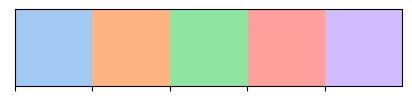

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
sns.palplot(colors)
sns.set_palette(colors)

## 4.1 社交网络数据

- 定义一个函数用于读取数据文件，每一行包含一条边，边用节点对表示。

In [2]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

- 读取 Facecook 数据集（可以从 [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html)下载）

In [3]:
# https://snap.stanford.edu/data/facebook_combined.txt.gz

fb = read_graph('data/facebook_combined.txt.gz')
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

- 对于较大的图，集聚系数和路径长度计算非常慢，花费的时间与 $nk^2$ 成正比，其中 $n$ 是节点数，$k$ 是每个节点连接到的相邻节点的数量。
- 幸运的是，NetworkX提供了一个函数，可以通过随机抽样估计集聚系数和路径长度。
- 可以使用如下代码调用该函数：

In [4]:
from networkx.algorithms.approximation import average_clustering
average_clustering(fb, trials=1000)

0.611

- 下面的函数对路径长度做了类似的处理。

In [5]:
def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) 
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

- 测试平均集聚系数

In [6]:
C = average_clustering(fb)
C

0.608

- 测试平均路径长度

In [7]:
L = estimate_path_length(fb)
L

3.717

## 4.2 WS 模型

- 我们构建和 Facebook 网络具有相同节点个数 $n=4039$ 和平均度 $\langle k \rangle=44$ 的WS图。

In [8]:
n = len(fb)
m = len(fb.edges())
k = int(round(2*m/n))
k

44

- 当 `p=0` 时我们得到一个环格。

In [9]:
lattice = nx.watts_strogatz_graph(n, k, p=0)
len(lattice), len(lattice.edges())

(4039, 88858)

- 计算集聚系数

In [10]:
C, average_clustering(lattice)

(0.608, 0.75)

- 计算平均路径长度

In [11]:
L, estimate_path_length(lattice)

(3.717, 47.088)

- 当 `p=1` 时我们得到一个随机图。

In [12]:
random_graph = nx.watts_strogatz_graph(n, k, p=1)

- 计算集聚系数

In [13]:
C, average_clustering(random_graph)

(0.608, 0.015)

- 计算平均路径长度

In [14]:
L, estimate_path_length(random_graph)

(3.717, 2.62)

- 通过反复试验并试错，发现当 $p=0.05$ 时，可以得到一个高集聚短路径长度的WS图。

In [15]:
ws = nx.watts_strogatz_graph(n, k, 0.05, seed=15)

- 计算集聚系数

In [16]:
C, average_clustering(ws)

(0.608, 0.624)

- 计算平均路径长度

In [17]:
L, estimate_path_length(ws)

(3.717, 3.264)

So that seems good so far.

## 4.3 度

- 我们研究一下原始数据集和WS模型的度分布。
- 如下函数返回一个度列表。

In [18]:
def degrees(G):
    """List of degrees for nodes in `G`.
    
    G: Graph object
    
    returns: list of int
    """
    return [G.degree(u) for u in G]

- 计算原始数据集和WS模型的平均度。

In [19]:
np.mean(degrees(fb)), np.mean(degrees(ws))

(43.69101262688784, 44.0)

- 计算标准差。

In [20]:
np.std(degrees(fb)), np.std(degrees(ws))

(52.41411556737521, 1.4309215628189869)

- 问题出在哪里？
- 我们研究下它们的度分布情况。
- 测试

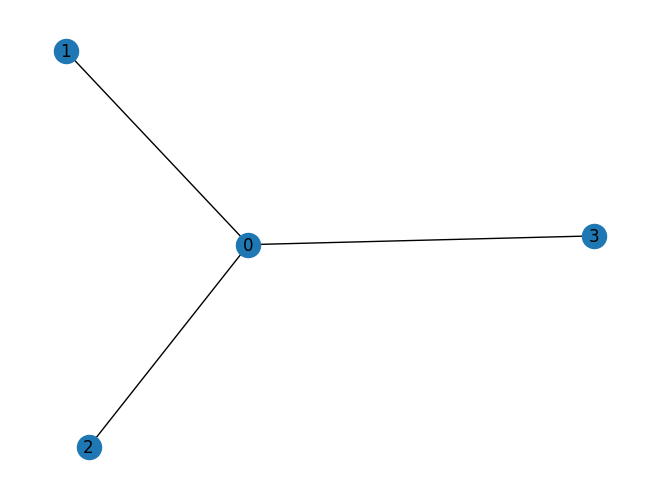

In [21]:
G = nx.Graph()
G.add_edge(1, 0)
G.add_edge(2, 0)
G.add_edge(3, 0)
nx.draw(G, with_labels=True)

- 度列表

In [24]:
degrees(G)

[1, 3, 1, 1]

- 为了计算度分布，我们使用 `empiricaldist` 的 `Pmf` 类。

In [25]:
from empiricaldist import Pmf

ModuleNotFoundError: No module named 'empiricaldist'

- 测试

In [51]:
pmf = Pmf.from_seq(degrees(G))
pmf

,probs
1,0.75
3,0.25


- 可视化

Text(0, 0.5, 'Pmf')

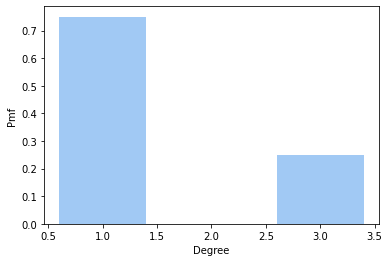

In [128]:
pmf.bar()
plt.xlabel('Degree')
plt.ylabel('Pmf')

- 我们使用 `Pmf` 计算均值和标准差。

In [55]:
pmf_fb = Pmf.from_seq(degrees(fb))
pmf_fb.mean(), pmf_fb.std()

(43.69101262688785, 52.41411556737521)

In [56]:
pmf_ws = Pmf.from_seq(degrees(ws))
pmf_ws.mean(), pmf_ws.std()

(44.00000000000001, 1.4309215628189869)

- 也可以使用 `Pmf` 检查度为 1 的节点的比例。

In [64]:
pmf_fb(1), pmf_ws(1)

(0.018568952711067097, 0)

- 绘制Facebook网络数据集和WS模型中节点的度的分布图。

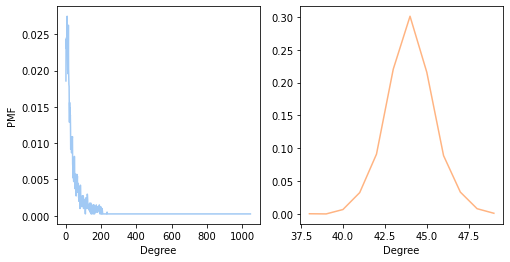

In [68]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
pmf_fb.plot(label='Facebook', color='C0')
plt.xlabel('Degree')
plt.ylabel('PMF')

plt.subplot(1,2,2)
pmf_ws.plot(label='WS graph', color='C1')
plt.xlabel('Degree')
# plt.ylabel('Pmf')

plt.savefig('figs/exp4-1')

- 在双对数坐标下绘制PMF图像。

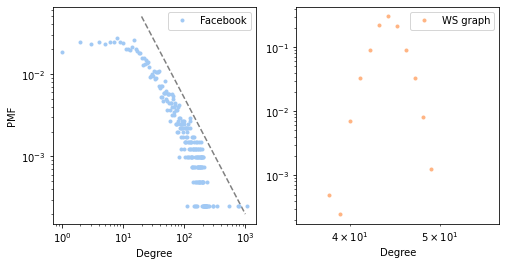

In [145]:
plt.figure(figsize=(8,4))
options = dict(ls='', marker='.')

plt.subplot(1,2,1)
plt.plot([20, 1000], [5e-2, 2e-4], color='gray', linestyle='dashed')

pmf_fb.plot(label='Facebook', color='C0', **options)
plt.xlabel('Degree')
plt.ylabel('PMF')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
pmf_ws.plot(label='WS graph', color='C1', **options)
plt.xlabel('Degree')
plt.xscale('log')
plt.yscale('log')
plt.axis(xmin=35, xmax=58)
plt.legend(loc="upper right")

plt.savefig('figs/exp4-2')